In [1]:
#Imports
from marketsai.economies.townsend.townsend_nested import Townsend_nested
import scipy.io as sio
from scipy.interpolate import RegularGridInterpolator
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init


/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = True  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_PROGRESS = True  # create plot with progress
SIMUL_PERIODS = 5000
# Input Directories
# Rl experiment
""" CHANGE HERE """
# INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native__multi_firm_townsend_nested_run_Sep6_PPO.json"
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native__multi_firm_townsend_nested_run_Sep7_PPO_mod.json"
# GDSGE policy
dir_policy_folder = (
    "/Users/matiascovarrubias/Dropbox/RL_macro/Econ_algos/townsend_nested/Results/"
)

# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/ALL/"
    

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)


In [3]:
""" Step 0: import experiment data and initalize empty output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)
print(exp_data_dict)

# UNPACK USEFUL DATA
n_agents_list = exp_data_dict["n_agents"]
exp_names = exp_data_dict["exp_names"]
checkpoints_dirs = exp_data_dict["checkpoints"]
progress_csv_dirs = exp_data_dict["progress_csv_dirs"]
#best_rewards = exp_data_dict["best_rewards"]


#Create output directory
exp_data_analysis_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
exp_data_analysis_econ_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
exp_data_simul_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
exp_data_simul_econ_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
# init ray
shutdown()
init()

#useful functions
def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]

#register environment
env_label = "townsend_nested"
register_env(env_label, Townsend_nested)

{'n_agents': [1, 2, 3, 4, 5], 'exp_names': ['native_townsend_nested_1_firms_Sep7_PPO_run', 'native_townsend_nested_2_firms_Sep7_PPO_run', 'native_townsend_nested_3_firms_Sep7_PPO_run', 'native_townsend_nested_4_firms_Sep7_PPO_run', 'native_townsend_nested_5_firms_Sep7_PPO_run'], 'exp_dirs': ['/Users/matiascovarrubias/ray_results/native_townsend_nested_1_firms_Sep7_PPO_run/PPO_townsend_nested_16dd8_00003_3_2021-09-07_22-45-31', '/Users/matiascovarrubias/ray_results/native_townsend_nested_2_firms_Sep7_PPO_run/PPO_townsend_nested_a6932_00002_2_2021-09-07_23-05-42', '/Users/matiascovarrubias/ray_results/native_townsend_nested_3_firms_Sep7_PPO_run/PPO_townsend_nested_647a6_00001_1_2021-09-07_23-53-57', '/Users/matiascovarrubias/ray_results/native_townsend_nested_4_firms_Sep7_PPO_run/PPO_townsend_nested_56dd2_00003_3_2021-09-08_01-23-24', '/Users/matiascovarrubias/ray_results/native_townsend_nested_5_firms_Sep7_PPO_run/PPO_townsend_nested_a8196_00000_0_2021-09-08_01-57-32'], 'progress_csv_di

2021-09-08 14:49:07,686	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


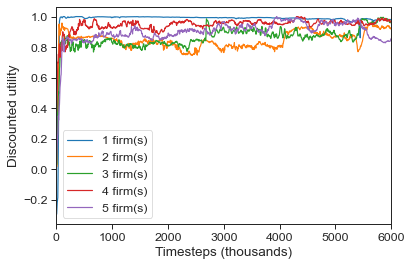

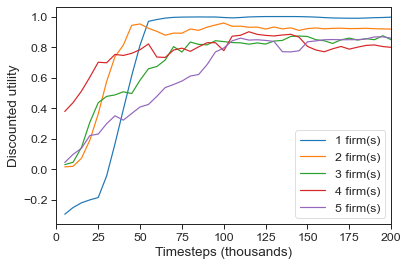

In [4]:
""" Step 1: Plot progress during learning run """

if PLOT_PROGRESS == True:
    #Big plot
    for i,n_firms in enumerate(n_agents_list):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = abs(data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max())
        print()
        exp_data_simul_dict["max rewards"].append(max_rewards)
        exp_data_simul_dict["time to peak"].append(0)
        exp_data_analysis_dict["max rewards"].append(max_rewards)
        exp_data_analysis_dict["time to peak"].append(0)
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] / max_rewards + 2
        
        learning_plot_big = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_big = learning_plot_big.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 6000])
    plt.legend(labels=[f"{n} firm(s)" for n in n_agents_list])
    learning_plot_big.savefig(OUTPUT_PATH_FIGURES + "progress_BIG_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()

    # small plot
    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / abs(max_rewards) +2
        )
        learning_plot_small = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_small = learning_plot_small.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 200])
    plt.legend(labels=[f"{n} firm(s)" for n in n_agents_list])
    learning_plot_small.savefig(OUTPUT_PATH_FIGURES + "progress_SMALL_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()


In [8]:
""" Step 2: Congif env, Restore RL policy and then simualte analysis trajectory """
rew_agg_list = [[] for i in n_agents_list]
y_agg_list = [[] for i in n_agents_list]

k_agg_list = [[] for i in n_agents_list]
k_mean_list = [[] for i in n_agents_list]
k_std_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]

rew_disc_list = [[] for i in n_agents_list]

p_mean_list = [[] for i in n_agents_list]
p_std_list = [[] for i in n_agents_list]
p_max_list = [[] for i in n_agents_list]
p_min_list = [[] for i in n_agents_list]

s_agg_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]


#shock_agg_list = [[] for i in n_agents_list]


for ind, n_firms in enumerate(n_agents_list):
    """ Step 2.0: replicate original environemnt and config """
    env_horizon = 200
    beta = 0.98
    env_config_analysis = {
        "horizon": env_horizon,
        "n_firms": n_firms,
        "n_inds": 2,
        "rental_shock": False,
        "eval_mode": False,
        "analysis_mode": True,
        "simul_mode": False,
        "max_savings": 0.5,
        "max_cap": 200,
        "max_price": 100,
        "rew_mean": 1220,
        "rew_std": 325,
        "normalize": False,
        "k_ss": 1,
        "parameters": {
            "delta": 0.04,
            "alpha": 1,
            "beta": beta,
            "phi": 1,
            "A": 1/n_firms,
            "tfp": 0.4,
            "rho": 0.8,
            "theta_0": 0,
            "var_w": 1,
            "var_epsilon": 1,
            "var_theta": 1,
        },
    }

    # We instantiate the environment to extract information.
    """ CHANGE HERE """
    env = Townsend_nested(env_config_analysis)
    config_algo = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_analysis,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "firm": (
                    None,
                    env.observation_space["firm_0"],
                    env.action_space["firm_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 2.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_algo)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Step 2: Simulate an episode (MAX_steps timesteps) """
    #shock_idtc_list = [[] for i in range(env.n_firms)]
    y_list = [[] for i in range(env.n_agents)]
    s_list = [[] for i in range(env.n_agents)]
    k_list = [[] for i in range(env.n_agents)]
    rew_list = [[] for i in range(env.n_agents)]
    p_list = [[] for i in range(env.n_inds)]

    # loop
    obs = env.reset()
    for t in range(env_horizon):
        action = {}
        for i in range(env.n_agents):
            action[f"firm_{i}"] = trained_trainer.compute_action(
                obs[f"firm_{i}"], policy_id="firm"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_agents):
            y_list[i].append(info["firm_0"]["income"][i])
            s_list[i].append(info["firm_0"]["savings"][i])
            k_list[i].append(info["firm_0"]["capital"][i])
            rew_list[i].append(info["firm_0"]["rewards"][i])
        
        for i in range(env.n_inds):
            p_list[i].append(info["firm_0"]["prices"][i])
  
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_agents)]))


        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_agents)]))
        k_mean_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_agents)]))
        k_std_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_agents)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_agents)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_agents)]))

        rew_disc_list[ind].append(np.mean([process_rewards(rew_list[i],0.98) for i in range(env.n_agents)]))

        p_max_list[ind].append(np.max([p_list[i][t] for i in range(env.n_inds)]))
        p_min_list[ind].append(np.min([p_list[i][t] for i in range(env.n_inds)]))
        p_mean_list[ind].append(np.max([p_list[i][t] for i in range(env.n_inds)]))
        p_std_list[ind].append(np.std([p_list[i][t] for i in range(env.n_inds)]))

        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_agents)])
            / y_agg_list[ind][t]
        )
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_agents)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_agents)]))


    """ Step 2.2: Calculate Statistics and save in table """

    exp_data_analysis_dict["n_firms"].append(n_firms)
    exp_data_analysis_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_analysis_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_analysis_dict["Mean Avge. K"].append(np.mean(k_mean_list[ind]))
    exp_data_analysis_dict["S.D. Avge. K"].append(np.std(k_mean_list[ind]))
    exp_data_analysis_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_analysis_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_analysis_dict["Discounted Rewards"].append(np.mean(rew_disc_list[ind]))



    exp_data_analysis_dict["Mean Price"].append(np.mean(p_mean_list[ind]))
    exp_data_analysis_dict["S.D. Price"].append(np.std(p_mean_list[ind]))
    exp_data_analysis_dict["Max Price"].append(np.max(p_max_list[ind]))
    exp_data_analysis_dict["Min Price"].append(np.min(p_min_list[ind]))

    exp_data_analysis_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_analysis_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_analysis_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_analysis_dict["Min s"].append(np.min(s_min_list[ind]))


    """ Step 2.3: Plot individual analysis trajectories """

    # Idiosyncratic trajectories
    x = [i for i in range(100)]
    plt.subplot(2, 2, 1)
    for i in range(env.n_inds):
        sn.lineplot(x,p_list[i][:100], label = f"industry {i+1}")
    plt.title("Price")

    plt.subplot(2, 2, 2)
    for i in range(env.n_firms):
        sn.lineplot(x,s_list[i][:100], label = f"firm {i+1}", legend=0)
    plt.title("Savings Rate")

    plt.subplot(2, 2, 3)
    for i in range(env.n_firms):
        sn.lineplot(x,y_list[i][:100], label = f"firm {i+1}", legend=0)
    plt.title("Income")

    plt.subplot(2, 2, 4)
    # plt.plot(k_agg_list[:100])
    for i in range(env.n_firms):
        sn.lineplot(x,k_list[i][:100], label = f"firm {i+1}", legend=0)
    plt.title("Capital")
    
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower right', prop={'size': 6})
    #plt.legend(labels=[f"{i+1} firms" for i in range(env.n_firms)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names[ind] + ".png")
    plt.show()
    plt.close()
 
print(exp_data_analysis_dict)

(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

KeyboardInterrupt: 

In [ ]:
""" Step 3: Create aggregate trajectory plots """

x = [i for i in range(100)]
plt.subplot(2, 2, 1)
for i in range(len(n_agents_list)):
    sn.lineplot(x,p_mean_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Average Price")

plt.subplot(2, 2, 2)
for i in range(len(n_agents_list)):
    sn.lineplot(x,y_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Income")

plt.subplot(2, 2, 3)
for i in range(len(n_agents_list)):
    sn.lineplot(x,s_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Savings Rate")

plt.subplot(2, 2, 4)
for i in range(len(n_agents_list)):
    sn.lineplot(x,k_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
plt.savefig(OUTPUT_PATH_FIGURES + "SimAgg_" + exp_names[-1] + ".png")
plt.show()
plt.close()

In [6]:
""" Step 4: Simulate the RL policy for SIMUL_PERIODS and get statistics """

y_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_mean_list = [[] for i in n_agents_list]
k_std_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
rew_disc_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
theta_list = [[] for i in n_agents_list]
p_mean_list = [[] for i in n_agents_list]
p_std_list = [[] for i in n_agents_list]
p_max_list = [[] for i in n_agents_list]
p_min_list = [[] for i in n_agents_list]

for ind, n_firms in enumerate(n_agents_list):
    """ Step 4.0: replicate original environemnt and config """
    env_horizon = 200
    n_firms = n_firms
    beta = 0.98
    env_config_simul = {
        "horizon": env_horizon,
        "n_inds": 2,
        "n_firms": n_firms,
        "rental_shock": False,
        "eval_mode": False,
        "analysis_mode": False,
        "simul_mode": True,
        "max_savings": 0.5,
        "max_cap": 200,
        "max_price": 100,
        # "rew_mean": 135.1329841811006,
        # "rew_std": 81.72997893645642,
        "rew_mean": 1220,
        "rew_std": 325,
        "normalize": False,
        "k_ss": 1,
        "parameters": {
            "delta": 0.04,
            "alpha": 1,
            "beta": 0.98,
            "phi": 1,
            "A": 1 / n_firms,
            "tfp": 0.4,
            "rho": 0.8,
            "theta_0": 0,
            "var_w": 1,
            "var_epsilon": 1,
            "var_theta": 1,
        },
    }

    # We instantiate the environment to extract information.
    """ CHANGE HERE """
    env = Townsend_nested(env_config_simul)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_simul,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "firm": (
                    None,
                    env.observation_space["firm_0"],
                    env.action_space["firm_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 4.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Simulate an episode (SIMUL_PERIODS timesteps) """

    y_list = [[] for i in range(env.n_agents)]
    s_list = [[] for i in range(env.n_agents)]
    k_list = [[] for i in range(env.n_agents)]
    p_list = [[] for i in range(env.n_agents)]
    rew_list = [[] for i in range(env.n_agents)]

    # loop
    obs = env.reset()
    for t in range(SIMUL_PERIODS):
        action = {}
        if t%env.horizon == 0:
            obs=env.reset()
        for i in range(env.n_agents):
            action[f"firm_{i}"] = trained_trainer.compute_action(
                obs[f"firm_{i}"], policy_id="firm"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_agents):
            y_list[i].append(info["firm_0"]["income"][i])
            s_list[i].append(info["firm_0"]["savings"][i])
            k_list[i].append(info["firm_0"]["capital"][i])
            rew_list[i].append(info["firm_0"]["rewards"][i])

        for i in range(env.n_inds):
            p_list[i].append(info["firm_0"]["prices"][i])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_firms)]))
        theta_list[ind].append(env.obs_global[2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_agents)]))

        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_agents)]))
        k_mean_list[ind].append(np.mean([k_list[i][t] for i in range(env.n_agents)]))
        k_std_list[ind].append(np.std([k_list[i][t] for i in range(env.n_agents)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_agents)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_agents)]))

        rew_disc_list[ind].append(np.mean([process_rewards(rew_list[i],0.98) for i in range(env.n_agents)]))

        p_mean_list[ind].append(np.mean([p_list[i][t] for i in range(env.n_inds)]))
        p_std_list[ind].append(np.std([p_list[i][t] for i in range(env.n_inds)]))
        p_max_list[ind].append(np.max([p_list[i][t] for i in range(env.n_inds)]))
        p_min_list[ind].append(np.min([p_list[i][t] for i in range(env.n_inds)]))


        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_agents)])
            / y_agg_list[ind][t]
        )
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_agents)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_agents)]))

    exp_data_simul_dict["n_firms"].append(n_firms)
    exp_data_simul_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_simul_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_simul_dict["Mean Avge. K"].append(np.mean(k_mean_list[ind]))
    exp_data_simul_dict["S.D. Avge. K"].append(np.std(k_mean_list[ind]))
    exp_data_simul_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_simul_dict["Min K"].append(np.min(k_min_list[ind]))

    exp_data_simul_dict["Discounted Rewards"].append(np.mean(rew_disc_list[ind]))

    exp_data_simul_dict["Mean Price"].append(np.mean(p_mean_list[ind]))
    exp_data_simul_dict["S.D. Price"].append(np.std(p_mean_list[ind]))
    exp_data_simul_dict["Max Price"].append(np.max(p_max_list[ind]))
    exp_data_simul_dict["Min Price"].append(np.min(p_min_list[ind]))

    exp_data_simul_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_simul_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_simul_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_simul_dict["Min s"].append(np.min(s_min_list[ind]))


print(exp_data_simul_dict) 

(pid=9651) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=9651) Instructions for updating:
(pid=9651) non-resource variables are not supported in the long term
(pid=9655) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=9655) Instructions for updating:
(pid=9655) non-resource variables are not supported in the long term
2021-09-08 14:50:59,081	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_townsend_nested_

{'n_firms': [1, 2, 3, 4, 5], 'max rewards': [76.58768822159364, 85.51232518504976, 85.28569047368312, 103.14001373518768, 87.71100870421384], 'time to peak': [0, 0, 0, 0, 0], 'Mean Agg. K': [284.87221127206965, 751.7019747334739, 1143.524233912209, 1530.0255394174878, 1882.9178150803932], 'S.D. Agg. K': [39.47648575073988, 133.05336375802355, 185.75474533303398, 248.4239783683722, 331.895992589774], 'Mean Avge. K': [142.43610563603482, 187.92549368336847, 190.58737231870154, 191.25319242718598, 188.29178150803926], 'S.D. Avge. K': [19.73824287536994, 33.26334093950589, 30.95912422217233, 31.052997296046524, 33.189599258977395], 'Max K': [176.05592952681192, 200.0, 200.0, 200.0, 200.0], 'Min K': [10.035558809233676, 10.807190296959487, 10.61265723378697, 10.581595657583796, 10.198753910012988], 'Discounted Rewards': [94519.51322397185, 73135.61421764204, 63846.94787491781, 64906.27230927526, 72450.9472649459], 'Mean Price': [43.00029342548466, 24.86076341816145, 23.71898519395956, 23.62

In [ ]:
""" Step 5: config env, Restore PI (GDSGE) policy and simulate analysis trajectory """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_firms in enumerate([1, 2, 3]):
    # replicate environment
    env_horizon = 1000
    n_firms = n_firms
    n_capital = 1
    beta = 0.98
    env_config_analysis = {
        "horizon": 1000,
        "n_firms": n_firms,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": False,
        "analysis_mode": True,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    """ CHANGE HERE """
    env = Townsend_nested(env_config_analysis)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_analysis,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "firm": (
                    None,
                    env.observation_space["firm_0"],
                    env.action_space["firm_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 5.1: import matlab struct """
    """ CHANGE HERE """
    dir_model = f"cap_market_{n_firms}firm_11pts"
    matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
    exp_data_analysis_econ_dict["time to peak"].append(
        matlab_struct["IterRslt"]["timeElapsed"]
    )
    exp_data_simul_econ_dict["time to peak"].append(
        matlab_struct["IterRslt"]["timeElapsed"]
    )
    if n_firms == 1:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K"]) for i in range(n_firms)
        ]
    else:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K_{i+1}"])
            for i in range(n_firms)
        ]
    shock_grid = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
    if n_firms == 1:
        s_on_grid = [matlab_struct["IterRslt"]["var_policy"]["s"] for i in range(n_firms)]
    else:
        s_on_grid = [
            matlab_struct["IterRslt"]["var_policy"][f"s_{i+1}"] for i in range(n_firms)
        ]

    s_interp = [
        RegularGridInterpolator((shock_grid,) + tuple(K_grid), s_on_grid[i])
        for i in range(n_firms)
    ]

    def compute_action(obs, policy_list: list, max_action: float):
        K = obs[0]
        shock_raw = [obs[2]] + list(obs[1])
        shock_id = encode(shock_raw, dims=[2 for i in range(env.n_firms + 1)])
        s = [policy_list[i](np.array([shock_id] + K)) for i in range(env.n_firms)]
        action = np.array([2 * s[i] / max_action - 1 for i in range(env.n_firms)])
        return action

    """ Step 5.2: Simulate an episode (MAX_steps timesteps) """
    shock_idtc_list = [[] for i in range(env.n_firms)]
    y_list = [[] for i in range(env.n_firms)]
    s_list = [[] for i in range(env.n_firms)]
    c_list = [[] for i in range(env.n_firms)]
    k_list = [[] for i in range(env.n_firms)]

    # loop
    obs = env.reset()
    for t in range(env_horizon):
        action = {}
        for i in range(env.n_firms):
            action[f"firm_{i}"] = compute_action(obs["firm_0"], s_interp, env.max_s_ij)[i]

        obs, rew, done, info = env.step(action)
        for i in range(env.n_firms):
            shock_idtc_list[i].append(obs["firm_0"][1][i])
            y_list[i].append(info["firm_0"]["income"][i])
            s_list[i].append(info["firm_0"]["savings"][i][0])
            c_list[i].append(info["firm_0"]["consumption"][i])
            k_list[i].append(info["firm_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_firms)]))
        shock_agg_list[ind].append(obs["firm_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_firms)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_firms)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_firms)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_firms)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_firms)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_firms)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_firms)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_firms)]))
        p_list[ind].append(info["firm_0"]["price"][0])

    """ Step 5.3: Calculate Statistics and save in table """


    exp_data_analysis_econ_dict["n_firms"].append(n_firms)
    exp_data_analysis_econ_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_analysis_econ_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_analysis_econ_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_analysis_econ_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_analysis_econ_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_analysis_econ_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_analysis_econ_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_analysis_econ_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_analysis_econ_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_analysis_econ_dict["S.D. Price"].append(np.std(p_list[ind]))
    exp_data_analysis_econ_dict["Max Price"].append(np.max(p_list[ind]))
    exp_data_analysis_econ_dict["Min Price"].append(np.min(p_list[ind]))

    """ Step 5.4: Plot individual trajectories """

    # Idiosyncratic trajectories
    x = [i for i in range(100)]
    plt.subplot(2, 2, 1)
    sn.lineplot(x, shock_agg_list[ind][:100], label=f"firm {i+1}", legend=0)
    plt.title("Shock")

    plt.subplot(2, 2, 2)
    for i in range(env.n_firms):
        sn.lineplot(x, s_list[i][:100], label=f"firm {i+1}", legend=0)
    plt.title("Savings Rate")

    plt.subplot(2, 2, 3)
    for i in range(env.n_firms):
        sn.lineplot(x, y_list[i][:100], label=f"firm {i+1}", legend=0)
    plt.title("Income")

    plt.subplot(2, 2, 4)
    # plt.plot(k_agg_list[:100])
    for i in range(env.n_firms):
        sn.lineplot(x, k_list[i][:100], label=f"firm {i+1}", legend=0)
    plt.title("Capital")

    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc="lower right", prop={"size": 6})
    # plt.legend(labels=[f"{i+1} firms" for i in range(env.n_firms)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names[ind] + ".png")
    plt.show()
    plt.close()

print(exp_data_analysis_econ_dict)

In [ ]:
""" STEP 6: Get aggregate trakectory plots for PI (GDSE)  """

x = [i for i in range(100)]
plt.subplot(2, 2, 1)
for i in range(len([1,2,3])):
    sn.lineplot(x,shock_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Shock")

plt.subplot(2, 2, 2)
for i in range(len([1,2,3])):
    sn.lineplot(x,y_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Income")

plt.subplot(2, 2, 3)
for i in range(len([1,2,3])):
    sn.lineplot(x,s_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Savings Rate")

plt.subplot(2, 2, 4)
for i in range(len([1,2,3])):
    sn.lineplot(x,k_agg_list[i][:100], label = f"{i+1} firm(s)", legend=0)
plt.title("Aggregate Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
plt.savefig(OUTPUT_PATH_FIGURES + "SimAgg_econ_" + exp_names[-1] + ".png")
plt.clf
plt.show()

In [ ]:
""" Step 7: Simulate the Plocy Iteration model and get statistics """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_firms in enumerate([1,2,3]):
    """ Step 7.0: replicate original environemnt and config """
    env_horizon = 1000
    n_firms = n_firms
    n_capital = 1
    beta = 0.98
    env_config_simul = {
        "horizon": 1000,
        "n_firms": n_firms,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": True,
        "analysis_mode": False,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = Townsend_nested(env_config_simul)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_simul,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "firm": (
                    None,
                    env.observation_space["firm_0"],
                    env.action_space["firm_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 7.1: restore trainer """

    dir_model = f"cap_market_{n_firms}firm_11pts"
    matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
    if n_firms == 1:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K"]) for i in range(n_firms)
        ]
    else:
        K_grid = [
            np.array(matlab_struct["IterRslt"]["var_state"][f"K_{i+1}"])
            for i in range(n_firms)
        ]
    shock_grid = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
    if n_firms == 1:
        s_on_grid = [matlab_struct["IterRslt"]["var_policy"]["s"] for i in range(n_firms)]
    else:
        s_on_grid = [
            matlab_struct["IterRslt"]["var_policy"][f"s_{i+1}"] for i in range(n_firms)
        ]

    s_interp = [
        RegularGridInterpolator((shock_grid,) + tuple(K_grid), s_on_grid[i])
        for i in range(n_firms)
    ]

    def compute_action(obs, policy_list: list, max_action: float, K_grid: list):
        K = [min(max(obs[0][i],min(K_grid[i])), max(K_grid[i])) for i in range(n_firms)]
        shock_raw = [obs[2]] + list(obs[1])
        shock_id = encode(shock_raw, dims=[2 for i in range(env.n_firms + 1)])
        s = [policy_list[i](np.array([shock_id] + K)) for i in range(env.n_firms)]
        action = np.array([2 * s[i] / max_action - 1 for i in range(env.n_firms)])
        return action

    """ Simulate an episode (SIMUL_PERIODS timesteps) """
    shock_idtc_list = [[] for i in range(env.n_firms)]
    y_list = [[] for i in range(env.n_firms)]
    s_list = [[] for i in range(env.n_firms)]
    c_list = [[] for i in range(env.n_firms)]
    k_list = [[] for i in range(env.n_firms)]

    # loop
    obs = env.reset()
    for t in range(SIMUL_PERIODS):
        action = {}
        if t%1000 == 0:
            obs=env.reset()
        for i in range(env.n_firms):
            action[f"firm_{i}"] = compute_action(obs["firm_0"], s_interp, env.max_s_ij, K_grid)[i]

        obs, rew, done, info = env.step(action)
        for i in range(env.n_firms):
            shock_idtc_list[i].append(obs["firm_0"][1][i])
            y_list[i].append(info["firm_0"]["income"][i])
            s_list[i].append(info["firm_0"]["savings"][i][0])
            c_list[i].append(info["firm_0"]["consumption"][i])
            k_list[i].append(info["firm_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_firms)]))
        shock_agg_list[ind].append(obs["firm_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_firms)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_firms)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_firms)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_firms)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_firms)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_firms)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_firms)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_firms)]))
        p_list[ind].append(info["firm_0"]["price"][0])

    exp_data_simul_econ_dict["n_firms"].append(n_firms)
    exp_data_simul_econ_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_simul_econ_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_simul_econ_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_simul_econ_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_simul_econ_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_simul_econ_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_simul_econ_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_simul_econ_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_simul_econ_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_simul_econ_dict["S.D. Price"].append(np.std(p_list[ind]))

print(exp_data_simul_econ_dict)

In [7]:
""" Step 8 and final: Table with moments """
exp_table_df = pd.DataFrame.from_dict(exp_data_simul_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_df.to_latex())

exp_table_small_df=exp_table_df[["n_firms","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_SMALL_TABLE.tex','w') as tf:
    tf.write(exp_table_small_df.to_latex())

# exp_table_econ_df = pd.DataFrame.from_dict(exp_data_simul_econ_dict)
# with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_econ_BIG_TABLE.tex','w') as tf:
#     tf.write(exp_table_econ_df.to_latex())

# exp_table_small_econ_df=exp_table_df[["n_firms","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
# with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_econ_SMALL_TABLE.tex','w') as tf:
#     tf.write(exp_table_small_econ_df.to_latex())

In [ ]:
shutdown()